<a href="https://colab.research.google.com/github/SiamDip/new-repo/blob/main/Deep_Learning_with_xAI_GradCAM%20new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GradCAM - Gradient Class Activation Map

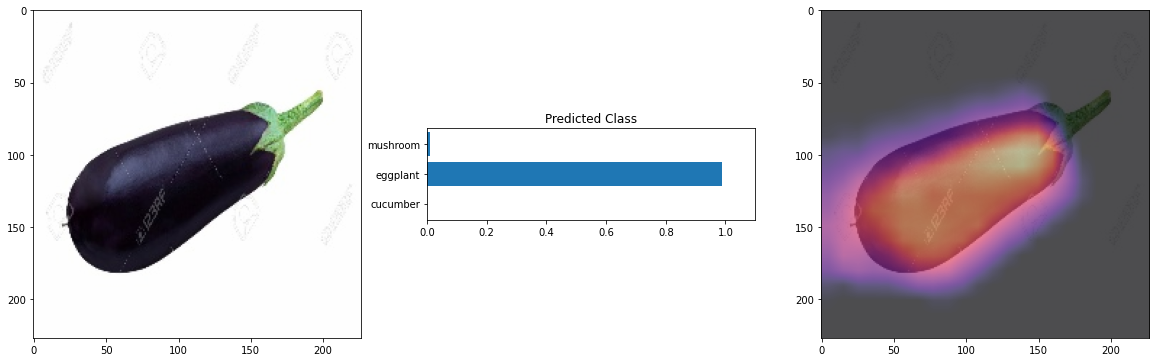

In [ ]:
!git clone https://github.com/parth1620/GradCAM-Dataset.git
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Cloning into 'GradCAM-Dataset'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 193 (delta 0), reused 193 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (193/193), 2.59 MiB | 24.53 MiB/s, done.
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-hl9ly1ss
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-hl9ly1ss
  Resolved https://github.com/albumentations-team/albumentations to commit edb09e36cfe68d159be2167d6b02fb44d995d5a1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 26.6 MB/s eta 0:00:00
  Created wheel for albumentations: filename

# Imports

In [ ]:
import sys
sys.path.append('/content/GradCAM-Dataset')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms as T

from tqdm import tqdm
import albumentations as A
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import utils

# Configurations

In [ ]:
CSV_FILE = "/content/GradCAM-Dataset/train.csv"
DATA_DIR = "/content/GradCAM-Dataset/"

DEVICE = 'cuda'

BATCH_SIZE = 16
LR = 0.001
EPOCHS = 20


In [ ]:
data = pd.read_csv(CSV_FILE)
data.head()

,img_path,label
0,train_images/mushroom_51.jpg,2
1,train_images/eggplant_37.jpg,1
2,train_images/mushroom_20.jpg,2
3,train_images/eggplant_51.jpg,1
4,train_images/eggplant_26.jpg,1


In [ ]:
# cucumber -- 0
# Eggplant -- 1
# Mushroom -- 2


train_df, valid_df = train_test_split(data, test_size =0.2, random_state = 42)

# Augmentations

In [ ]:
train_augs = A.Compose([
    A.Rotate(),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

])

valid_augs = A.Compose([
    A.Normalize(mean= [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

# Load Image Dataset

In [ ]:
trainset = utils.ImageDataset( train_df, augs = train_augs, data_dir=DATA_DIR)
validset = utils.ImageDataset( valid_df, augs = valid_augs, data_dir=DATA_DIR)

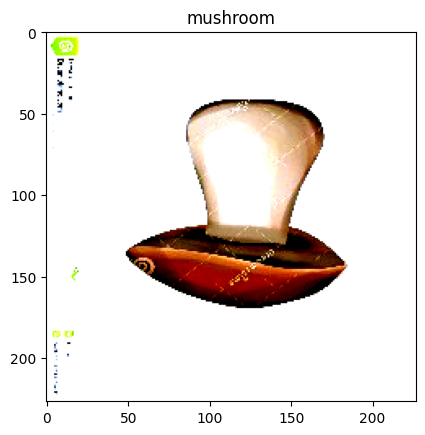

In [ ]:
image, label = trainset[14] #(channel , height, width) to (height, width, channel)

class_list = ['cucumber', 'eggplant', 'mushroom']

plt.imshow(image.permute(1,2,0))
plt.title(class_list[label]);

In [ ]:
print(f"No. of examples in the train {len(trainset)}")
print(f"No. of examples in the val {len(validset)}")

No. of examples in the train 148
No. of examples in the val 38


# Load Dataset into Batches

In [ ]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [ ]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 10
No. of batches in validloader : 3


In [ ]:
for images, labels in trainloader:
    break

print(f"One batch image shape : {images.shape}")
print(f"One batch label shape : {labels.shape}")

One batch image shape : torch.Size([16, 3, 227, 227])
One batch label shape : torch.Size([16])


# Create Model

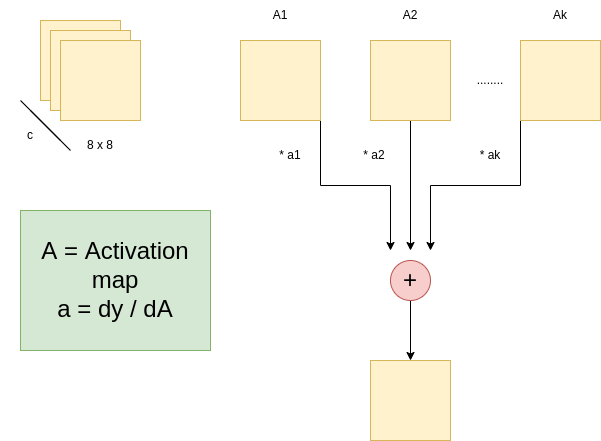

In [ ]:
from torch.nn.modules.pooling import MaxUnpool2d
class ImageModel(nn.Module):

  def __init__(self):
    super(ImageModel, self).__init__()

    self.feature_extractor = nn.Sequential(

        nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = (5,5), padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (4,4), stride= 2),

        nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (5,5), padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (4,4), stride= 2),

        nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (5,5), padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (4,4), stride= 2),

        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (5,5), padding = 1),
        nn.ReLU(),

    )
    self.maxpool = nn.MaxPool2d(kernel_size = (4,4), stride = 2)
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(6400, 2048),
        nn.Linear(2048, 3)
    )

    self.gradient = None

  def activations_hook(self, grad):
    self.gradient = grad          # This will return our weights

  def forward(self, images):
    x = self.feature_extractor(images)  # er output amra Activation map (A) hishebe use korbo

    print(x.shape)
    h= x.register_hook(self.activations_hook)
    print(h)
    x = self.maxpool(x)
    x = self.classifier(x)

    return x

  def get_activation_gradients(self):  # a1, a2, a3 ... ak i.e. dy/dA
    return self.gradient

  def get_activations(self, x): # will return A1, A2, ... Ak  (combined channels, height, width)
    return self.feature_extractor(x)


In [ ]:
model = ImageModel()
model.to(DEVICE)

ImageModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6400, out_features=2048, bias=True)
    (2): Linear(in_features=2048, out_features=3, bias=True)
  )
)

# Create Train and Eval function

In [ ]:
def train_fn(dataloader, model, optimizer, criterion):
  model.train()
  total_loss = 0.0
  for images, labels in tqdm(dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    optimizer.zero_grad()
    logits = model(images)
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()

    total_loss +=loss.item()
  return total_loss / len(dataloader)

In [ ]:
def eval_fn(dataloader, model, criterion):
  model.eval()
  total_loss = 0.0
  for images, labels in tqdm(dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)


    logits = model(images)
    loss = criterion(logits, labels)


    total_loss +=loss.item()
  return total_loss / len(dataloader)

# Training Loop

In [ ]:
BATCH_SIZE = 16
LR = 0.001
EPOCHS = 2

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr= LR)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
best_valid_loss = np.inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer, criterion)
  valid_loss = eval_fn(validloader, model, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_weights.pt')
    best_valid_loss = valid_loss
    print("Saved weights success")

  print(f"EPOCH : {i+1} TRAIN LOSS: {train_loss} VALID LOSS: {valid_loss}")


  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([16, 64, 22, 22])


 30%|███       | 3/10 [00:01<00:02,  2.46it/s]

torch.Size([16, 64, 22, 22])
torch.Size([16, 64, 22, 22])
torch.Size([16, 64, 22, 22])
torch.Size([16, 64, 22, 22])


 70%|███████   | 7/10 [00:01<00:00,  6.35it/s]

torch.Size([16, 64, 22, 22])
torch.Size([16, 64, 22, 22])
torch.Size([16, 64, 22, 22])
torch.Size([16, 64, 22, 22])


100%|██████████| 10/10 [00:01<00:00,  5.15it/s]


torch.Size([4, 64, 22, 22])


100%|██████████| 3/3 [00:00<00:00, 36.64it/s]


torch.Size([16, 64, 22, 22])
torch.Size([16, 64, 22, 22])
torch.Size([6, 64, 22, 22])
Saved weights success
EPOCH : 1 TRAIN LOSS: 1.7422526240348817 VALID LOSS: 1.047460635503133


 20%|██        | 2/10 [00:00<00:00, 17.98it/s]

torch.Size([16, 64, 22, 22])
torch.Size([16, 64, 22, 22])
torch.Size([16, 64, 22, 22])


 40%|████      | 4/10 [00:00<00:00, 17.81it/s]

torch.Size([16, 64, 22, 22])


 60%|██████    | 6/10 [00:00<00:00, 17.40it/s]

torch.Size([16, 64, 22, 22])
torch.Size([16, 64, 22, 22])
torch.Size([16, 64, 22, 22])


 80%|████████  | 8/10 [00:00<00:00, 17.17it/s]

torch.Size([16, 64, 22, 22])


100%|██████████| 10/10 [00:00<00:00, 18.66it/s]


torch.Size([16, 64, 22, 22])
torch.Size([4, 64, 22, 22])


100%|██████████| 3/3 [00:00<00:00, 43.85it/s]

torch.Size([16, 64, 22, 22])
torch.Size([16, 64, 22, 22])
torch.Size([6, 64, 22, 22])


Saved weights success
EPOCH : 2 TRAIN LOSS: 0.9071456849575043 VALID LOSS: 0.7921776374181112


# Get GradCAM

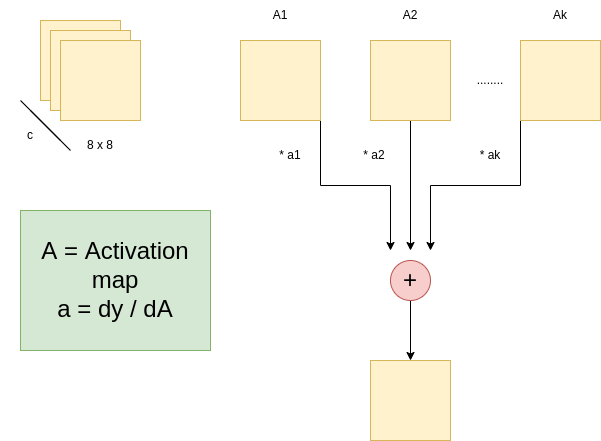

In [ ]:
def get_gradecam(model, image, label, size):

  label.backward()
  gradients = model.get_activation_gradients()
  pooled_gradients = torch.mean(gradients, dim=[0, 2, 3]) # alpha1, alpha2, alpha3 ...
  activations = model.get_activations(image).detach() # A1, A2
  print(activations.shape)

  for i in range(activations.shape[1]):    # i.e. cnn filters
    activations[:, i, :, :] *= pooled_gradients[i]

  heatmap = torch.mean(activations, dim=1).squeeze().cpu()
  heatmap = nn.ReLU()(heatmap)
  heatmap /= torch.max(heatmap)
  heatmap = cv2.resize(heatmap.numpy(), (size, size))

  return heatmap

In [ ]:
type(validset[7][0])

torch.Tensor

torch.Size([1, 64, 22, 22])
torch.Size([1, 64, 22, 22])


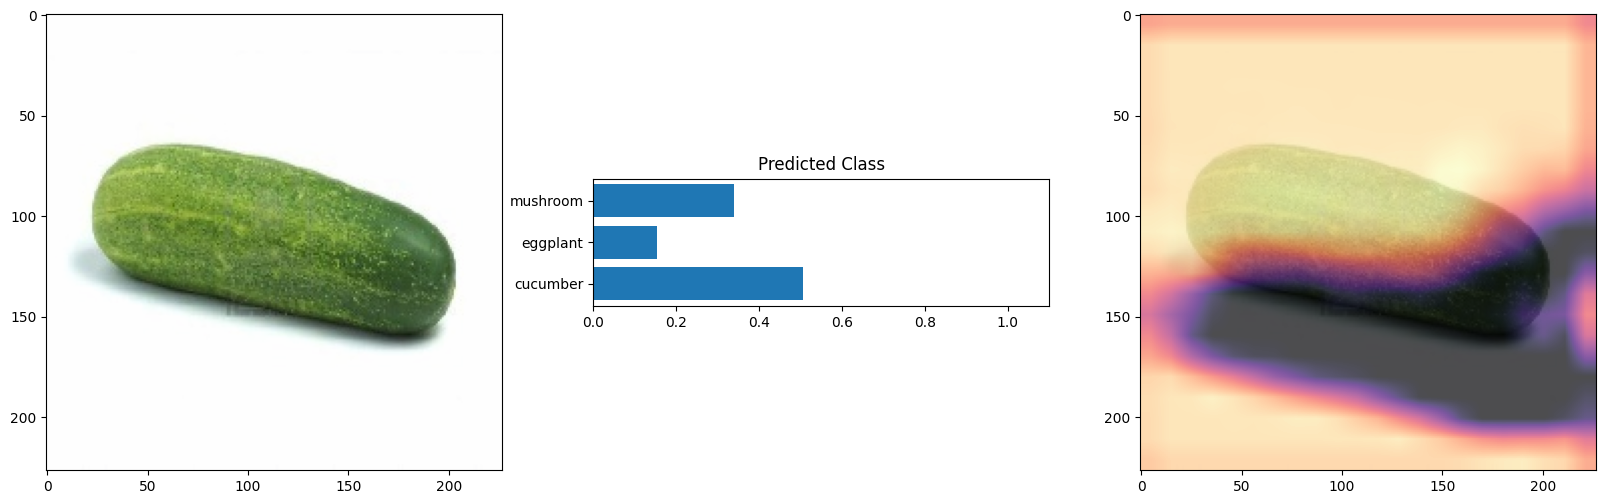

In [ ]:
image, label = validset[7]

denorm_image = image.permute(1, 2, 0) * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
image = image.unsqueeze(0).to(DEVICE)

pred = model(image)
heatmap = get_gradecam(model, image, pred[0][2], size=227)  # 1 is label here i.e. eggplant

utils.plot_heatmap(denorm_image, pred, heatmap)

In [ ]:
heatmap.shape

(227, 227)